In [ ]:
import os
import numpy as np
import tensorflow as tf
from skimage.util import view_as_blocks
import albumentations as A
from tqdm import tqdm
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

print("✅ Libraries imported\n")

✅ Libraries imported



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive mounted")

Mounted at /content/drive

✅ Google Drive mounted


In [ ]:
# Directory Path of Pneumothorax
BasePath = "/content/drive/MyDrive/siim-acr-pneumothorax/"
# Directory Path of Train Images
TrainImageDir = os.path.join(BasePath, "train_images")
# Directory Path of Train Masks
TrainMskDir = os.path.join(BasePath, "train_masks")

print("\n🔍 Scanning dataset...")
# Display all files in Train Image
AllFiles = [f for f in os.listdir(TrainImageDir) if f.endswith('.png')]
# Display Positive Files showing Pneumothorax
PositiveFiles = [f for f in AllFiles if f.split('_')[2] == '1']
# Display Negative Files showing no Pneumothorax
NegativeFiles = [f for f in AllFiles if f.split('_')[2] == '0']

print(f"\n📊 Dataset Stats:")
# Display the total no of samples
print(f" - Total samples in the training folder: {len(AllFiles):,}")
# Display the no of Positive Cases
print(f" - Positive cases: {len(PositiveFiles):,} (pneumothorax)")
# Display the no of Negative Cases
print(f" - Negative cases: {len(NegativeFiles):,}")


🔍 Scanning dataset...

📊 Dataset Stats:
 - Total samples in the training folder: 4,471
 - Positive cases: 923 (pneumothorax)
 - Negative cases: 3,548



🔍 Detailed Dataset Analysis


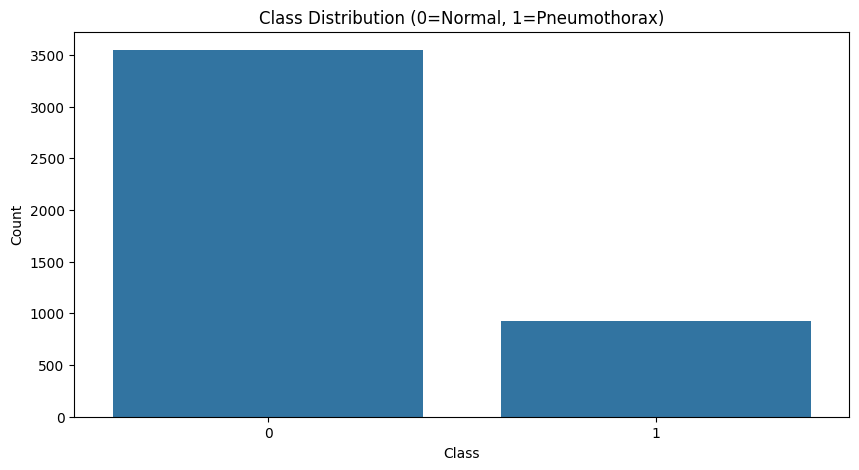


📈 Class Ratio: 3.8:1 (Normal:Pneumothorax)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print("\n🔍 Detailed Dataset Analysis")
print("="*50)

# Class Distribution Analysis
plt.figure(figsize=(10,5))
# Extract class labels
sns.countplot(x=[f.split('_')[2] for f in AllFiles])
# Set plot title
plt.title("Class Distribution (0=Normal, 1=Pneumothorax)")
# X-axis label (Class)
plt.xlabel("Class")
# Y-axis label (Count)
plt.ylabel("Count")
# Display plot
plt.show()

# Class imbalance ratio
print(f"\n📈 Class Ratio: {len(NegativeFiles)/len(PositiveFiles):.1f}:1 (Normal:Pneumothorax)")


[ ] Creating balanced dataset...
[✔] Selected 1800 files (900 positive, 900 negative)

[ ] Displaying sample images...


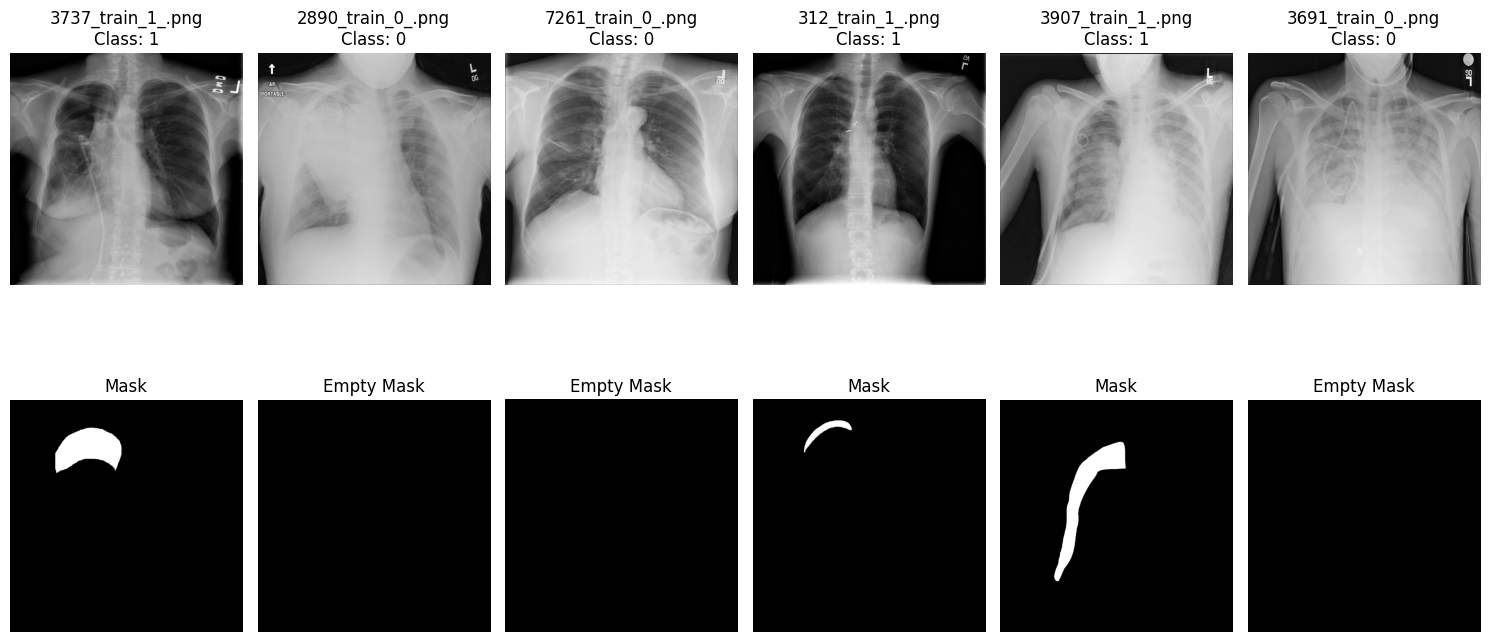

In [ ]:
import random

# Create balanced dataset
print("\n[ ] Creating balanced dataset...")
SampleSize = 900
BalancedFiles = (
    random.sample(PositiveFiles, SampleSize) +
    random.sample(NegativeFiles, SampleSize)
)
# Shuffle the balanced files
random.shuffle(BalancedFiles)

print(f"[✔] Selected {len(BalancedFiles)} files ({SampleSize} positive, {SampleSize} negative)")

# Displaying sample images
print("\n[ ] Displaying sample images...")
plt.figure(figsize=(15, 8))
# Loop through first 6 files
for i, filename in enumerate(BalancedFiles[:6]):
    # Read images
    img = plt.imread(os.path.join(TrainImageDir, filename))
    # Read masks
    mask = plt.imread(os.path.join(TrainMskDir, filename))
    # Plot the top row image
    plt.subplot(2, 6, i+1)
    plt.imshow(img, cmap='gray')
    # Plot the filename and the class
    plt.title(f"{filename}\nClass: {filename.split('_')[2]}")
    plt.axis('off')

    # Bottom row mask
    plt.subplot(2, 6, i+7)
    # Display the grayscale mask
    plt.imshow(mask, cmap='gray')
    # Status of the mask
    plt.title("Mask" if mask.max() > 0 else "Empty Mask")
    # Hide the axes
    plt.axis('off')

# Adjust the layout spacing
plt.tight_layout()
# Display the figure
plt.show()

In [ ]:
from PIL import Image
import random


# Verify positive cases having valid masks
valid_PositiveFiles = []
# Initialize the Empty Mask Count to 0
EmptyMskCount = 0
# Looping over the Positive Files
for f in tqdm(PositiveFiles, desc="Checking positive cases"):
    mask = np.array(Image.open(os.path.join(TrainMskDir, f)))
    # Check whether the maximum of mask is greater than 0
    if mask.max() > 0:
        # Append the positive files to Valid Positive Files
        valid_PositiveFiles.append(f)
    else:
        # Count the no of EmptyMask
        EmptyMskCount += 1

# Computing the ratio for the positive cases with empty masks
print(f"[❗] Found {EmptyMskCount}/{len(PositiveFiles)} positive cases with empty masks")

Checking positive cases: 100%|██████████| 923/923 [05:03<00:00,  3.05it/s]

[❗] Found 0/923 positive cases with empty masks


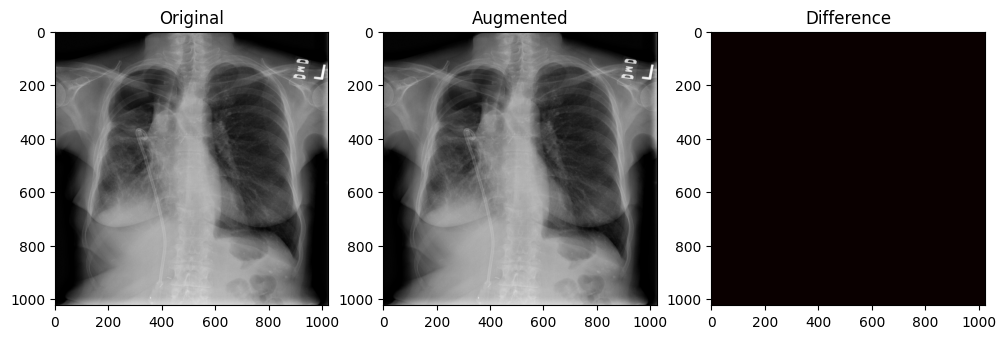

In [ ]:

import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Perform Augmentation
aug = A.Compose([
    # Flip Horizontally
    A.HorizontalFlip(p=0.5),
    # Flip Vertically
    A.VerticalFlip(p=0.3),
    # Small Rotation
    A.Rotate(limit=15, p=0.5),
    # Adjust the brightness
    A.RandomBrightnessContrast(p=0.3),
    A.ElasticTransform(p=0.1)
    # Include the masks as additional targets
], additional_targets={'mask': 'mask'})


class PneumoDataset:
    def __init__(self, file_list, img_dir, mask_dir, batch_size=8):
        # File list
        self.file_list = file_list
        # Image directory
        self.img_dir = img_dir
        # Mask Directory
        self.mask_dir = mask_dir
        # Batch size
        self.batch_size = batch_size

    def __len__(self):
        # Total no of batches
        return len(self.file_list) // self.batch_size

    def __getitem__(self, idx):
        # Select Batch files
        BatchFiles = self.file_list[idx*self.batch_size:(idx+1)*self.batch_size]
        # Image List
        X = []
        # Mask list
        y = []
        for f in BatchFiles:
            img = np.array(Image.open(os.path.join(self.img_dir, f))) / 255.0
            mask = (np.array(Image.open(os.path.join(self.mask_dir, f))) > 0).astype(float)
            X.append(img[..., np.newaxis])
            y.append(mask[..., np.newaxis])
        return np.array(X), np.array(y)


# Create the Train Generator
TrainGen = PneumoDataset(
    BalancedFiles,
    TrainImageDir,
    TrainMskDir,
    batch_size=8
)


def augment_data(X, y):
    # First Batch
    BatchX, BatchY = [], []
    for img, mask in zip(X, y):
        if np.random.rand() > 0.5:
            # Display the Augmented image
            AugResult = aug(image=img.squeeze(), mask=mask.squeeze())
            img, mask = AugResult['image'][..., np.newaxis], AugResult['mask'][..., np.newaxis]
        # Append images
        BatchX.append(img)
        # Append mask
        BatchY.append(mask)
    return np.array(BatchX), np.array(BatchY)

# First Batch
Samplex, SampleY = TrainGen[0]
# Apply Augmentation
Augx, Augy = augment_data(Samplex, SampleY)

plt.figure(figsize=(12,4))
# The First Plot
plt.subplot(1,3,1)
plt.imshow(Samplex[0].squeeze(), cmap='gray')
plt.title("Original")

# The Second Plot
plt.subplot(1,3,2)
# Display the Augmented image
plt.imshow(Augx[0].squeeze(), cmap='gray')
# Plot the title
plt.title("Augmented")

# The Third Plot
plt.subplot(1,3,3)
# Display the difference
plt.imshow(np.abs(Samplex[0].squeeze()-Augx[0].squeeze()), cmap='hot')
# Plot the title
plt.title("Difference")
# Display the plot
plt.show()

In [ ]:
# Shape of Sample batch
print(f"Sample batch shape: {Samplex.shape}")
# Shape of Augmented batch
print(f"Augmented batch shape: {Augx.shape}")

Sample batch shape: (8, 1024, 1024, 1)
Augmented batch shape: (8, 1024, 1024, 1)


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model

# Load Base Model
BaseModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Create feature extractor
FeatureExtractor = Model(inputs=BaseModel.input, outputs=BaseModel.output)

print("✅ ResNet50 model loaded for feature extraction.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ ResNet50 model loaded for feature extraction.


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_preprocess_image_mask(file, img_dir, mask_dir):
    # Load and resize image (to RGB, ResNet compatible)
    img = Image.open(os.path.join(img_dir, file)).convert("RGB").resize((224, 224))
    ImageArray = img_to_array(img)
    ImageArray = preprocess_input(ImageArray)

    # Load and resize mask (preserve binary structure)
    mask = Image.open(os.path.join(mask_dir, file)).resize((224, 224), Image.NEAREST)
    MaskArray = np.array(mask)

    return ImageArray, MaskArray

# Containers for valid data xData, YLabels
xData, YLabels = [], []

print("\n🌀 Processing and filtering valid data...")

# Loop through Balanced files
for f in tqdm(BalancedFiles):
    ImageArray, MaskArray = load_and_preprocess_image_mask(f, TrainImageDir, TrainMskDir)

    # Check mask content for positive cases
    label = int(f.split('_')[2])
    if label == 1 and MaskArray.max() == 0:
        continue

    # Append image
    xData.append(ImageArray)
    # Append label
    YLabels.append(label)

# Convert into array
xData = np.array(xData)
# Convert into array
YLabels = np.array(YLabels)

# Display the shape and length of xData
print(f"\n✅ Final dataset: {len(xData)} images (Shape: {xData.shape})")
# Display the counts of 2 different classes
print(f"📌 Class distribution: {np.bincount(YLabels)} (0=Normal, 1=Pneumothorax)")



🌀 Processing and filtering valid data...


100%|██████████| 1800/1800 [14:57<00:00,  2.01it/s]



✅ Final dataset: 1800 images (Shape: (1800, 224, 224, 3))
📌 Class distribution: [900 900] (0=Normal, 1=Pneumothorax)


In [ ]:
# Extract deep features from ResNet
features = FeatureExtractor.predict(xData, batch_size=16, verbose=1)

# Flatten the features
FlatFeatures = features.reshape(features.shape[0], -1)

# Save FlatFeatures and YLabels to Disk
np.save("features.npy", FlatFeatures)
np.save("labels.npy", YLabels)

print("✅ Features and labels saved to disk.")
# Shape of FlatFeatures
print(f" - Features shape: {FlatFeatures.shape}")
# Shape of YLabels
print(f" - Labels shape: {YLabels.shape}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step
✅ Features and labels saved to disk.
 - Features shape: (1800, 100352)
 - Labels shape: (1800,)


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Load ALL training features and labels
xTrain = np.load("features.npy")
YTrain = np.load("labels.npy")

# Initialize the Logistic Regression Model
logreg = LogisticRegression(
    class_weight="balanced",  #
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
# Train the Logistic Regression Model
logreg.fit(xTrain, YTrain)
print("✓ Trained on ALL training data.")

✓ Trained on ALL training data.


In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications import ResNet50
FeatureExtractor = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

def extract_features(img_dir, max_images=2000):
    """Identical to your training feature extraction, but limited to max_images"""
    files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
    files = files[:max_images]
    X = []
    for f in tqdm(files, desc="Extracting features"):
        img = Image.open(os.path.join(img_dir, f)).convert("RGB").resize((224, 224))
        ImageArray = img_to_array(img)
        ImageArray = preprocess_input(ImageArray)
        X.append(ImageArray)

    X = np.array(X)
    features = FeatureExtractor.predict(X, batch_size=16, verbose=1)
    return features.reshape(features.shape[0], -1)

TestImageDir = "/content/drive/MyDrive/siim-acr-pneumothorax/test_images"
XTestFeatures = extract_features(TestImageDir, max_images=2000)
print(f"✅ Test features shape: {XTestFeatures.shape} (Should match training: (N, 100352))")



Extracting features: 100%|██████████| 2000/2000 [04:58<00:00,  6.71it/s]


125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step
✅ Test features shape: (2000, 100352) (Should match training: (N, 100352))


In [ ]:
# Save XTestFeatures to disk
np.save("test_features.npy", XTestFeatures)


In [ ]:
import numpy as np
import os

TestImageDir = "/content/drive/MyDrive/siim-acr-pneumothorax/test_images"

# Reuse the same list of files used for feature extraction
files = [f for f in os.listdir(TestImageDir) if f.endswith('.png')][:2000]

# Extract labels from filename
labels = [int(f.split('_')[2]) for f in files]
# Convert labels to array
labels = np.array(labels)

# Save labels to disk
np.save("test_labels.npy", labels)

print(f"✅ Labels saved. Shape: {labels.shape}")

✅ Labels saved. Shape: (2000,)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Load test test_features and test_labels
XTest = np.load("test_features.npy")
YTest = np.load("test_labels.npy")

# Predict using the trained Logistic Regression model
YPred = logreg.predict(XTest)

# Evaluate using classification report
print(classification_report(YTest, YPred))
# Evaluate using accuracy
print("Accuracy:", accuracy_score(YTest, YPred))


              precision    recall  f1-score   support

           0       0.99      0.77      0.87      1844
           1       0.24      0.87      0.38       156

    accuracy                           0.78      2000
   macro avg       0.61      0.82      0.62      2000
weighted avg       0.93      0.78      0.83      2000

Accuracy: 0.779


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Load xTrain, YTrain,XTest and YTest
xTrain = np.load("features.npy")
YTrain = np.load("labels.npy")
XTest = np.load("test_features.npy")
YTest = np.load("test_labels.npy")

# Principal Component Analysis (PCA)
pca = PCA(n_components=100)
# Transform xTrain
xTrain_pca = pca.fit_transform(xTrain)
# Transform XTest
XTest_pca = pca.transform(XTest)
# Display Variance
print(f"✅ PCA done. Variance retained: {np.sum(pca.explained_variance_ratio_):.2f}")

# XGBoost with imbalance handling
XgbModel = xgb.XGBClassifier(
    scale_pos_weight=(sum(YTrain == 0) / sum(YTrain == 1)),
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=1,
    random_state=42
)
# Train XgbModel
XgbModel.fit(xTrain_pca, YTrain)

# Predict the performance of model
YPred = XgbModel.predict(XTest_pca)
print("✅ XGBoost Results (with PCA):")
# Evaluate Accuracy
print("Accuracy:", accuracy_score(YTest, YPred))
# Evaluate classification report
print(classification_report(YTest, YPred))


✅ PCA done. Variance retained: 0.50


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:46:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost Results (with PCA):
Accuracy: 0.724
              precision    recall  f1-score   support

           0       0.98      0.71      0.83      1844
           1       0.20      0.86      0.33       156

    accuracy                           0.72      2000
   macro avg       0.59      0.79      0.58      2000
weighted avg       0.92      0.72      0.79      2000



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Transform of xTrain and XTest
xTrain_pca = pca.fit_transform(xTrain)
XTest_pca = pca.transform(XTest)

# Initialize Random Forest Model
RfModel = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Train the RfModel
RfModel.fit(xTrain_pca, YTrain)

# Predict the performance of model
YPred_rf = RfModel.predict(XTest_pca)
print("Random Forest Results:")
# Evaluate the accuracy
print("Accuracy:", accuracy_score(YTest, YPred_rf))
# Evaluate the classification report
print(classification_report(YTest, YPred_rf))

Random Forest Results:
Accuracy: 0.7525
              precision    recall  f1-score   support

           0       0.98      0.74      0.85      1844
           1       0.22      0.86      0.35       156

    accuracy                           0.75      2000
   macro avg       0.60      0.80      0.60      2000
weighted avg       0.92      0.75      0.81      2000



In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


# Load the features, labels, test_features and test_labels
xTrain = np.load("features.npy")
YTrain = np.load("labels.npy")
XTest = np.load("test_features.npy")
YTest = np.load("test_labels.npy")

# Normalize the features
scaler = StandardScaler()
xTrain_scaled = scaler.fit_transform(xTrain)
XTest_scaled = scaler.transform(XTest)

# Initialize the SVM model
SvmModel = SVC(kernel='linear', C=1, probability=True, random_state=42)

# Train the SVM model
SvmModel.fit(xTrain_scaled, YTrain)

# Prediction of the model performance
YPred_svm = SvmModel.predict(XTest_scaled)

# Evaluate using classification report and accuracy
print("SVM Accuracy:", accuracy_score(YTest, YPred_svm))
print(classification_report(YTest, YPred_svm))

SVM Accuracy: 0.771
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      1844
           1       0.24      0.86      0.37       156

    accuracy                           0.77      2000
   macro avg       0.61      0.81      0.61      2000
weighted avg       0.93      0.77      0.82      2000



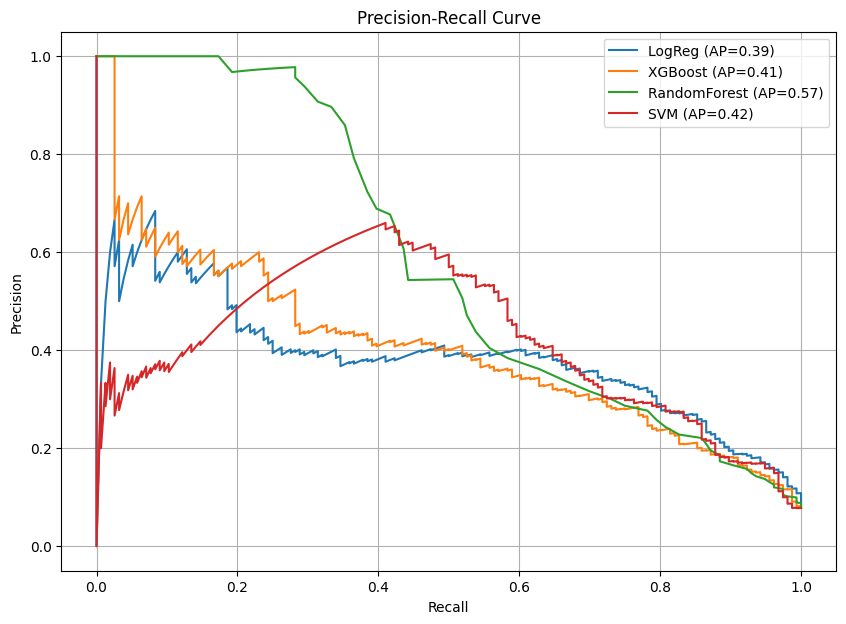

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))

# Logistic Regression
YProbalogreg = logreg.predict_proba(XTest)[:, 1]
# Evaluate using Precision and Recall Curve
precision, recall, _ = precision_recall_curve(YTest, YProbalogreg)
# Evaluate using Average Precision Score
ap = average_precision_score(YTest, YProbalogreg)
# plot logreg pr
plt.plot(recall, precision, label=f'LogReg (AP={ap:.2f})')

# XGBoost
YProbaXgb = XgbModel.predict_proba(XTest_pca)[:, 1]
# Evaluate using Precision and Recall Curve
precision, recall, _ = precision_recall_curve(YTest, YProbaXgb)
# Evaluate using Average Precision Score
ap = average_precision_score(YTest, YProbaXgb)
# plot XGBoost pr
plt.plot(recall, precision, label=f'XGBoost (AP={ap:.2f})')

# Random Forest
YProbaRf = RfModel.predict_proba(XTest_pca)[:, 1]
# Evaluate using Precision and Recall Curve
precision, recall, _ = precision_recall_curve(YTest, YProbaRf)
# Evaluate using Average Precision Score
ap = average_precision_score(YTest, YProbaRf)
# plot Random Forest pr
plt.plot(recall, precision, label=f'RandomForest (AP={ap:.2f})')

# Optional: SVM (only if trained with probability=True)
try:
    YProbaSvm = SvmModel.predict_proba(XTest_scaled)[:, 1]
    # Evaluate using Precision and Recall Curve
    precision, recall, _ = precision_recall_curve(YTest, YProbaSvm)
    # Evaluate using Average Precision Score
    ap = average_precision_score(YTest, YProbaSvm)
    # plot svm pr
    plt.plot(recall, precision, label=f'SVM (AP={ap:.2f})')
except:
    print("⚠️ SVM doesn't support predict_proba. Skipping PR curve for SVM.")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
